# Data Driven Network Science
Supplementary code for the Data Driven Network Science summative paper

**Candidate number**: 1080738

## Preliminaries

In [2]:
## libraries
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pycountry
import seaborn as sns
import os
import sys
import random 
import copy
import geopandas as gpd

from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh
from scipy.integrate import quad
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import ttest_ind
from scipy.integrate import simps
from shapely.geometry import Point, LineString

**Note**: the code below imports a cleaned + imputed version of the UNHCR refugee data discussed in the paper, from my Github repository: https://github.com/1080738/data-driven-network-science/tree/main. 

The repository contains all files and code for cleaning the data. 
- The "summative_code" folder contains two files: 
    - 'unhcr_cleaning_data.R' contains the R code used to clean the raw UNHCR data ('unhcr_unimputed.csv')
    - 'unhcr_imputing_data.ipynb' contains Python code for imputing the output of 'unhcr_cleaning_data.R' ('unhcr_unimputed.csv')
- The "summative_data" folder contains 4 files: 
    - 'population.csv': raw refugee data file downloaded from UNHCR website
    - 'unhcr_unimputed.csv': cleaned but unimputed UNHCR data (output from 'unhcr_cleaning_data.R')
    - 'dat_imputed.csv': cleaned + imputed UNHCR data (output from 'unhcr_imputing_data.ipynb')
    - 'TEK-2021.csv': raw data for ethnic kin network, from the TEK website.

## Data

###  Function converting tabular data to network graph

In [8]:
## conversion function
def df_to_network_foryear (orig_filter, 
                           year, 
                           edge_from, 
                           show_plot = True, 
                           spring = True): 
    
    # isolating origin country
    dat = df_subset [df_subset['orig'] == orig_filter]
    dat = dat [dat['year'] == year]
    
    # check if country is present in the 'orig' column
    if orig_filter not in dat['orig'].values:
        print(f"'{orig_filter}' not found in 'orig' column for the year {year}")
        return None
    
    # creating a pivot table to get total refugees between each orig and dest country
    adjacency_matrix = pd.pivot_table(dat, 
                                      values = edge_from, 
                                      index = 'orig', 
                                      columns = 'dest', 
                                      aggfunc = 'sum',
                                      fill_value = 0)

    # add missing columns/rows if orig/dest countries are missing
    all_countries = set (dat['orig'].unique()).union (set(dat['dest'].unique()))
    adjacency_matrix = adjacency_matrix.reindex (index = all_countries, 
                                                 columns = all_countries, 
                                                 fill_value = 0)

    
    # weighted graph from adj matrix
    G = nx.from_pandas_adjacency (adjacency_matrix)
    
    # node label
    node_labels = {node: node for node in G.nodes}
    
    # if show_plot = True
    if show_plot:
        
        # fig baseline
        plt.figure (figsize = (10, 6))
        
        # positioning
        if spring: 
            pos = nx.spring_layout(G)  # positioning nodes using spring layout algorithm
        else:
            pos = nx.random_layout(G)
        
        # positioning of labels
        pos_labels = {key: (value[0], value[1] + 0.05) for key, value in pos.items()} # label positions
        
        nx.draw_networkx (G, pos, 
                        with_labels = True,
                        labels = node_labels, 
                        node_size = 10, 
                        node_color = 'skyblue', 
                        font_size = 10, 
                        font_weight = 'bold')
        edge_labels = nx.get_edge_attributes (G, 'weight')
        #nx.draw_networkx_edge_labels (G, pos, edge_labels = edge_labels)
        
        # setting title
        if edge_from == "forced_mig":
            plt.title (f'Refugee Flow Network out of {orig_filter} in {year}')
        elif edge_from == "link":
            plt.title (f'Ethno-cultural Linkage Network out of {orig_filter} in {year}')
        else: 
            plt.title (f'Network out of {orig_filter} in {year}')
        
        plt.title (f'Refugee Flow Network out of {orig_filter} in {year}')
        plt.show()
    
    # return network graph object as well
    return G

### Importing tabular UNHCR data

In [27]:
## importing cleaned + imputed data from Github repository
url = "https://raw.githubusercontent.com/1080738/data-driven-network-science/master/summative_data/dat_imputed.csv"
df = pd.read_csv(url)

In [28]:
## check data is right
display (df.sample (10))

,orig_dest_year,orig_dest,orig,dest,year,forced_mig
95901,AFG_SAU_2003,AFG_SAU,AFG,SAU,2003,122.000000
137672,RWA_UKR_2014,RWA_UKR,RWA,UKR,2014,5.000000
86689,SYR_GBR_2001,SYR_GBR,SYR,GBR,2001,60522.532470
113401,SRB_NLD_2008,SRB_NLD,SRB,NLD,2008,1991.000000
164858,TKM_FRA_2022,TKM_FRA,TKM,FRA,2022,53.000000
97634,BGR_DNK_2004,BGR_DNK,BGR,DNK,2004,2056.328902
15834,MLI_FRA_1982,MLI_FRA,MLI,FRA,1982,97630.407874
147693,AFG_TUR_2017,AFG_TUR,AFG,TUR,2017,163413.000000
50475,ERI_SOM_1991,ERI_SOM,ERI,SOM,1991,84628.484546
110734,RUS_ECU_2007,RUS_ECU,RUS,ECU,2007,24.000000


### Testing the conversion of UNHCR data to refugee flow network

In [29]:
## filtering data down
df_subset = pd.DataFrame (df[['orig', 'dest', 'year', 'forced_mig']])

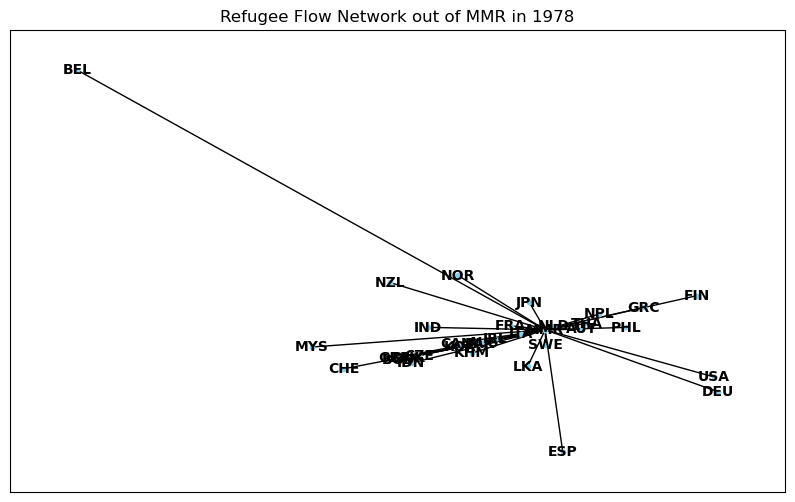

In [30]:
## testing function
G_rohingya = df_to_network_foryear ('MMR', 1978, edge_from = "forced_mig")

### Importing tabular TEK data

In [18]:
## raw TEK data
tek = pd.read_csv ("https://raw.githubusercontent.com/1080738/data-driven-network-science/master/summative_data/TEK-2021.csv")

In [19]:
## examining unique values
unique_values = tek['statename'].nunique()
print("Number of unique values in the statename column:", unique_values)

Number of unique values in the statename column: 160


In [20]:
## display TEK data sample to check if it's right 
display (tek.sample (10))

,tekid,gwid,statename,gwgroupid,groupname
639,1010,481,Gabon,48103000,Fang
442,417,450,Liberia,45003060,Kru
167,225,346,Bosnia-Herzegovina,34604000,Roma
558,516,816,"Vietnam, Democratic Republic of",81613000,Khmer
590,602,710,China,71011000,Yao
23,115,145,Bolivia,14503000,Quechua
439,417,437,Cote D'Ivoire,43702000,Kru
86,207,346,Bosnia-Herzegovina,34601000,Bosniaks/Muslims
310,303,692,Bahrain,69202000,Shi'a Arabs
306,303,678,Yemen (Arab Republic of Yemen),67802000,Northerners


In [21]:
## subsettng data to only contain the features I need to build the ethnic kin networks
tek_subset = tek[['statename', 'tekid']]
display (tek_subset.sample (10))

,statename,tekid
189,Russia (Soviet Union),230
451,Zimbabwe (Rhodesia),419
626,Belize,1004
438,Libya,416
406,Liberia,407
535,Cambodia (Kampuchea),500
520,"Congo, Democratic Republic of (Zaire)",443
629,India,1005
106,German Democratic Republic,214
504,Malawi,438


In [22]:
## converting TEK statename to ISO3 codes (to allow matching with the refugee data))
def get_iso3 (country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None
    
tek_subset['ISO3'] = tek_subset['statename'].apply(get_iso3)
tek_subset.loc[tek_subset['statename'] == "Bosnia-Herzegovina", 'ISO3'] = "BIH"
tek_subset = tek_subset.dropna (subset = ['ISO3'])
tek_subset2 = tek_subset[['ISO3', 'tekid']]

display (tek_subset2.sample(10))

/var/folders/0b/vncdd5yn4z1fxqccvhyddj0c0000gn/T/ipykernel_93087/1675412892.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tek_subset['ISO3'] = tek_subset['statename'].apply(get_iso3)


,ISO3,tekid
432,MRT,415
157,ESP,225
77,AZE,205
338,IND,352
305,SAU,303
424,ZMB,412
214,TJK,234
206,EST,233
272,TUN,301
368,PAK,360


In [23]:
## creating ethnic kinship linkage column
df_subset['link'] = df_subset.apply (
    lambda row: 1 if (row['orig'] in tek_subset2['ISO3'].values) and (row['dest'] in tek_subset2['ISO3'].values) else 0, axis = 1
    )

### Testing the conversion of TEK data to ethnic kinship network

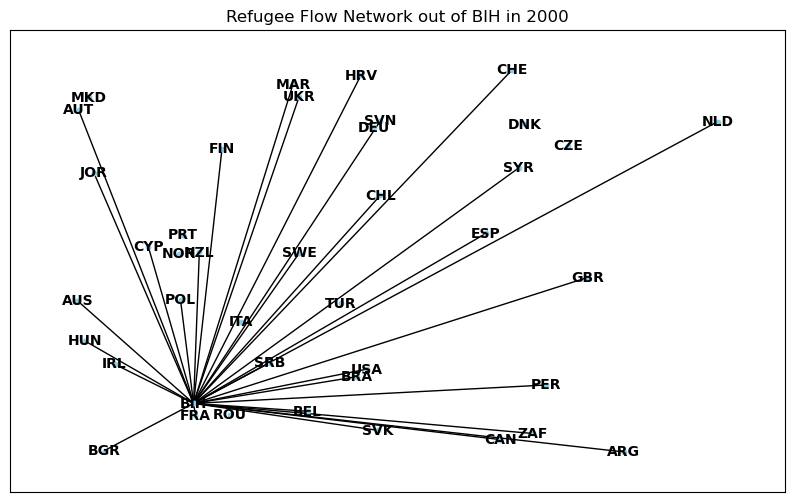

In [24]:
## function to build a network out of it 
G_test = df_to_network_foryear ('BIH', 2000, edge_from = "link", spring = False)

## Creating network map visuals

In [ ]:
## network map visual function
def create_migration_map(ax, data, orig_filter, year_min_filter, ctry):

    # filtering  data
    mapdat = data.loc[(data['orig'] == orig_filter) & (data['year'] >= year_min_filter)].dropna (subset = ['forced_mig'])

    # getting unique countries
    countries = pd.concat ([mapdat['orig'], mapdat['dest']]).unique()

    # nodes dataframe with geog information
    nodes = pd.DataFrame ({'id': range(1, len(countries) + 1), 'name': countries})

    # getting world map
    world = gpd.read_file (gpd.datasets.get_path ('naturalearth_lowres'))

    # getting centroids
    centroids = world.centroid

    # df with centroids
    centroids_df = pd.DataFrame ({'name': world['iso_a3'], 'lon': centroids.x, 'lat': centroids.y})

    # merging nodes with centroids
    nodes = pd.merge (nodes, centroids_df, on = 'name')

    # creating edges
    edges = mapdat.groupby (['orig', 'dest', 'link'])['forced_mig'].sum().reset_index()
    all_vertices = pd.concat ([edges['orig'], edges['dest']]).unique()
    nodes = nodes[nodes['name'].isin(all_vertices)]

    # adding id info
    edges_for_plot = pd.merge (edges, nodes[['name', 'lon', 'lat']], left_on = 'orig', right_on = 'name').rename (columns = {'lon': 'x', 'lat': 'y'})
    edges_for_plot = pd.merge (edges_for_plot, nodes[['name', 'lon', 'lat']], left_on = 'dest', right_on = 'name').rename (columns = {'lon': 'xend', 'lat': 'yend'})

    # creating the map
    world.boundary.plot (color = "#515151", linewidth = 0.15, ax = ax)
    for i, row in edges_for_plot.iterrows():
        color = 'blue' if row['link'] == 1 else 'red'

        # creating an arc between the points
        arc = mpatches.FancyArrowPatch((row['x'], row['y']), (row['xend'], row['yend']), 
                                       connectionstyle = "arc3,rad=.5", 
                                       arrowstyle = "-", color = color, alpha = 0.5)
        ax.add_patch(arc)

    # making a custom legend
    import matplotlib.lines as mlines
    blue_line = mlines.Line2D ([], [], color = 'blue', markersize = 15, label = 'Ethnic Kin')
    red_line = mlines.Line2D ([], [], color = 'red', markersize = 15, label = 'No Ethnic Kin')
    ax.legend (handles = [blue_line, red_line])

    # nodes plot
    ax.scatter (nodes['lon'], nodes['lat'], color = 'white', edgecolor = 'black', linewidth = 1, s = 10, alpha = 0.5)
    ax.set_title (f"Refugee Flows out of {ctry} in {year_min_filter}")

    # returning final plot
    return ax

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/981443751.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/981443751.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = world.centroid
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/981443751.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datas

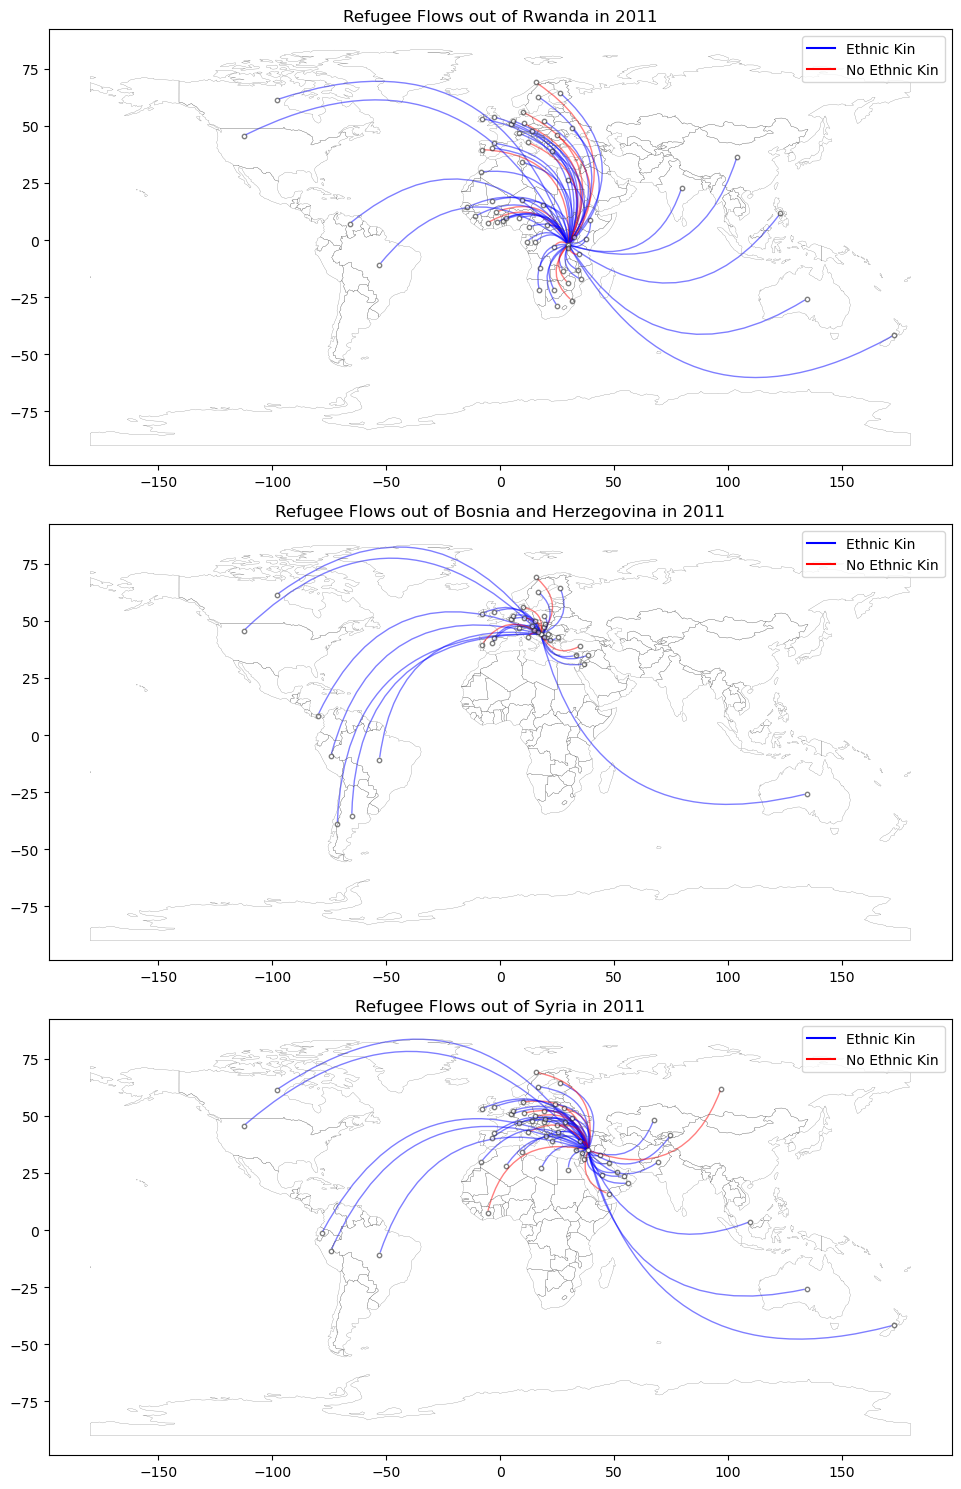

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (15, 15))

create_migration_map (ax[0], df_subset, "RWA", 2011, "Rwanda")
create_migration_map (ax[1], df_subset, "BIH", 2011, "Bosnia and Herzegovina")
create_migration_map (ax[2], df_subset, "SYR", 2011, "Syria")

plt.tight_layout()
plt.show()

## Implementing Distances

### Jaccard Distance

In [32]:
## Jacccard weighted distance function
def weighted_jaccard_distance(G1, G2):
    
    '''
    Function to compute the weighted version of the Jaccard distance between two graphs
    using their adjacency matrices
    
    - Input: a pair of network graph objects
    - Output: Jaccard distance coefficient
    '''
    
    # getting adjacency matrices of the graphs
    A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
    A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight = 'weight').todense()

    # computing numerator and denominator of the weighted Jaccard distance formula
    numerator = np.sum (np.abs (A1 - A2))
    denominator = np.sum (np.maximum (A1, A2))

    # computing the weighted Jaccard distance
    jaccard_distance = numerator / denominator
    return jaccard_distance

In [33]:
## testing it out
G_MMR_1978 = df_to_network_foryear ('MMR', 1978, edge_from = 'forced_mig', show_plot = False) # creating network 1 
G_MMR_2000 = df_to_network_foryear ('MMR', 2000, edge_from = 'forced_mig', show_plot = False) # creating network 2
distance = weighted_jaccard_distance (G_MMR_1978, G_MMR_2000) # getting Jaccard distance 
print("Weighted Jaccard Distance:", distance)

Weighted Jaccard Distance: 0.7869303408716872


/var/folders/0b/vncdd5yn4z1fxqccvhyddj0c0000gn/T/ipykernel_93087/487117341.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
/var/folders/0b/vncdd5yn4z1fxqccvhyddj0c0000gn/T/ipykernel_93087/487117341.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight = 'weight').todense()


### Ipsen-Mikhailov Distance

In [34]:
## IM distance function
def weighted_ipsenMikhailov_distance (G1, G2, gamma = 0.1, limit = 100): 

    '''
    Function to compute the weighted version of the Ipsen-Mikhailov distance between two graphs
    using their adjacency matrices. 

    - Input(s): 
        G1, G2 -> a pair of network graph objects
        gamma -> damping factor for the spectral density
        limit -> limit for the numerical integration
    - Output: Polynomial distance coefficient
    '''
    
    # weighted adjacency matrices
    A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
    A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight = 'weight').todense()

    # baseline function for IM distances
    def IMdistance (A1, A2, gamma): 

        # number of nodes 
        n = len(A1)

        # spectral density of A1 
        L1 = laplacian (A1, normed = False) # Laplacian matrix
        w1 = np.sqrt (np.abs (eigh (L1)[0][1:])) # vibrational frequency
        norm1 = (n - 1) * np.pi / 2 - np.sum (np.arctan (-w1 / gamma)) # normalisation constant (l2 norm)
        density1 = lambda w: np.sum (gamma / ((w - w1) ** 2 + gamma**2)) / norm1 # spectral density (equation 5 in paper)

        # spectral density of A2
        L2 = laplacian (A2, normed = False) # Laplacian matrix
        w2 = np.sqrt (np.abs (eigh (L2)[0][1:])) # vibrational frequency
        norm2 = (n - 1) * np.pi / 2 - np.sum (np.arctan (-w2 / gamma)) # normalisation constant (l2 norm)
        density2 = lambda w: np.sum (gamma / ((w - w2) ** 2 + gamma**2)) / norm2 # spectral density (equation 5 in paper)

        # getting the IM distance using the two spectral densities (equation 6 in paper)
        return np.sqrt (quad (lambda w: (density1(w) - density2(w)) ** 2, 
                              0, 
                              np.inf, 
                              limit = limit)[0])
    
    # computing distance
    distance = IMdistance (A1, A2, gamma)
    return distance

In [35]:
## testing it out
distanceIM = weighted_ipsenMikhailov_distance (G_MMR_1978, G_MMR_2000)
print("Weighted IM Distance:", distanceIM)

Weighted IM Distance: 0.2584214744010062


/var/folders/0b/vncdd5yn4z1fxqccvhyddj0c0000gn/T/ipykernel_93087/2968091926.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
/var/folders/0b/vncdd5yn4z1fxqccvhyddj0c0000gn/T/ipykernel_93087/2968091926.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight = 'weight').todense()
/var/folders/0b/vncdd5yn4z1fxqccvhyddj0c0000gn/T/ipykernel_93087/2968091926.py:32: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  o

### Polynomial Distance

In [40]:
## polynomial distance function
def weighted_polynomial_distance (G1, G2, k = 2, alpha = 1): 
    
    '''
    Function to compute the polynomial spectral distance between two graphs
    using the polynomial transformation of their adjacency matrices. 
    
    - Input(s): 
            G1, G2 -> a pair of network graph objects
            k -> maximum degree of the polynomial used in 
                 the polynomial dissimilarity distance calculation
            alpha -> parameter controlling the influence of the 
                 polynomial transformation on the similarity score calculation
    - Output: Polynomial distance coefficient
    '''
    
    # weighted adjacency matrices
    A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
    A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight = 'weight').todense()
    
    # P(A) (i.e. equation 8 in my paper) 
    def p_A (A, k, alpha): 
        
        # eigen-decomposition
        eigVals, eigVec = np.linalg.eig(A)
        
        # defining polynomial p(x) 
        def p_x(degree):

            # equation 7 in my paper
            return eigVals ** degree / (np.shape(A)[0] - 1) ** (alpha * (degree - 1))
        
        # diagonal matrix constructed from the sum of the polynomial transformations
        W = np.diag (sum([p_x(k) for k in range (1, k + 1)]))
        
        # polynomial transformation of the adjacency matrix 
        pA = np.dot (np.dot (eigVec, W), eigVec.T)
        return pA
    
    # applying polynomial to each adjacency matrix
    p_A1 = p_A (A1, k, alpha)
    p_A2 = p_A (A2, k, alpha)

    # getting N
    N = A1.shape[0]
    
    # polynomial distance
    polyDist = np.linalg.norm (p_A1 - p_A2) / N ** 2 # uses 2-norm by default
    return polyDist

In [42]:
## testing it out
distancePoly = weighted_polynomial_distance (G_MMR_1978, G_MMR_2000)
print("Weighted Polynomial Distance:", distancePoly)

Weighted Polynomial Distance: 20204172.858345773


/var/folders/0b/vncdd5yn4z1fxqccvhyddj0c0000gn/T/ipykernel_93087/3620508783.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
/var/folders/0b/vncdd5yn4z1fxqccvhyddj0c0000gn/T/ipykernel_93087/3620508783.py:21: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight = 'weight').todense()


## Similarity matrices H

In [ ]:
## function to create matrix
def create_dissimilarity_matrix (graphs, similarity_function):
    num_graphs = len(graphs)
    dissimilarity_matrix = [[0] * num_graphs for _ in range(num_graphs)]
    for i in range(num_graphs):
        for j in range(i+1, num_graphs):
            dissimilarity_matrix[i][j] = similarity_function (graphs[i], graphs[j])
            dissimilarity_matrix[j][i] = dissimilarity_matrix[i][j]
    return dissimilarity_matrix

### Rwanda

In [ ]:
## parameters
orig_filter = "RWA"
max_year = df_subset['year'].max()
min_year = df_subset['year'].min()
years = range (min_year, max_year + 1)

## empty graph storing object
graphs_RWA = []  

## loop to create yearly graphs for RWA
for year in years:
    G = df_to_network_foryear (orig_filter, year, "forced_mig", show_plot = False)
    if G:
        graphs_RWA.append (G)

In [ ]:
## computing dissimilarity matrix
dissimilarity_matrix_RWA_jaccard = create_dissimilarity_matrix (graphs_RWA, weighted_jaccard_distance)
dissimilarity_matrix_RWA_IM = create_dissimilarity_matrix (graphs_RWA, weighted_ipsenMikhailov_distance)
dissimilarity_matrix_RWA_poly = create_dissimilarity_matrix (graphs_RWA, weighted_polynomial_distance)

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1851550651.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight='weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1851550651.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight='weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1751056022.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1751056022.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix

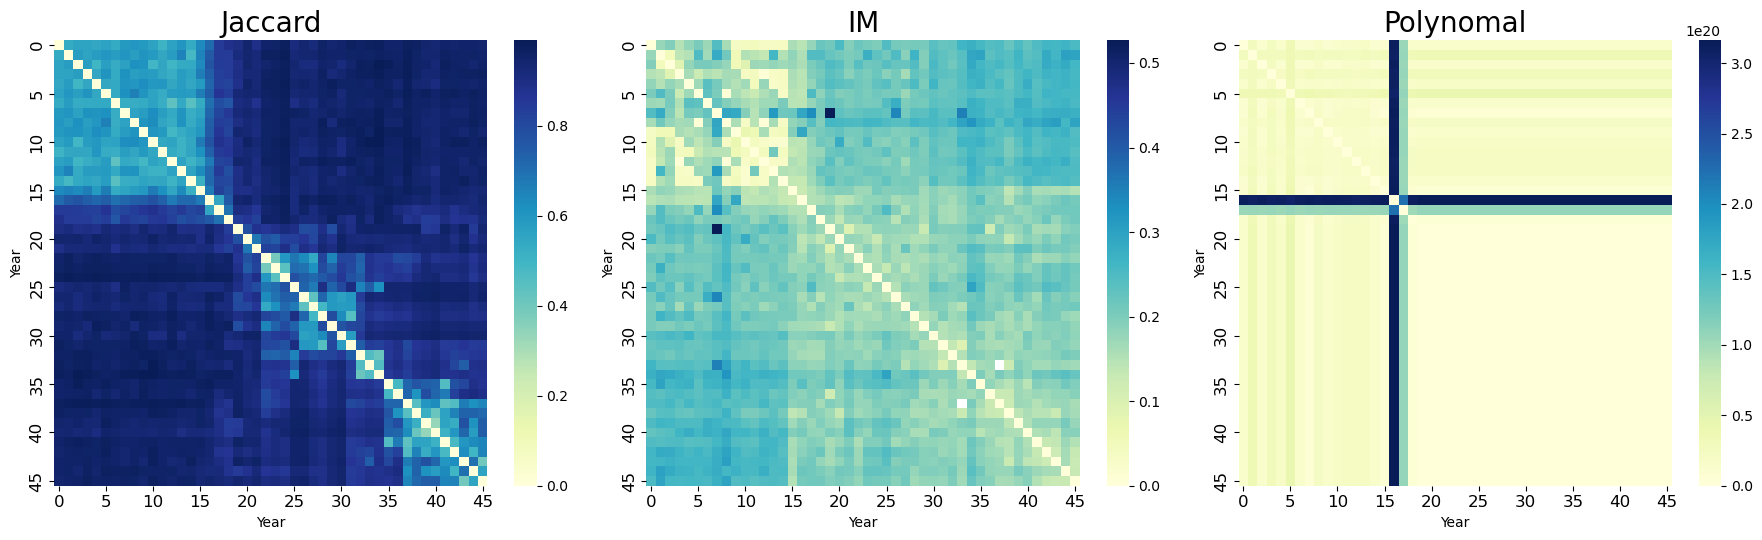

In [ ]:
# Create subplots for each dissimilarity matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

# Plot heatmap for dissimilarity matrix 1
sns.heatmap(dissimilarity_matrix_RWA_jaccard, annot=False, cmap="YlGnBu", xticklabels=5, yticklabels=5, fmt=".2f", ax=axes[0])
axes[0].set_title("Jaccard", fontsize=20)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Year")
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot heatmap for dissimilarity matrix 2
sns.heatmap(dissimilarity_matrix_RWA_IM, annot=False, cmap="YlGnBu", xticklabels=5, yticklabels=5, fmt=".2f", ax=axes[1])
axes[1].set_title("IM", fontsize=20)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Year")
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Plot heatmap for dissimilarity matrix 3
sns.heatmap(dissimilarity_matrix_RWA_poly, annot=False, cmap="YlGnBu", xticklabels=5, yticklabels=5, fmt=".2f", ax=axes[2])
axes[2].set_title("Polynomal", fontsize=20)
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Year")
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

### Bosnia-Herzegovina 

In [ ]:
## parameters
orig_filter = "BIH"
max_year = df_subset['year'].max()
min_year = df_subset['year'].min()
years = range (min_year, max_year + 1)

## empty graph storing object
graphs_BIH = []  

## loop to create yearly graphs for RWA
for year in years:
    G = df_to_network_foryear (orig_filter, year, "forced_mig", show_plot = False)
    if G:
        graphs_BIH.append (G)

In [ ]:
## computing dissimilarity matrix
dissimilarity_matrix_BIH_jaccard = create_dissimilarity_matrix (graphs_BIH, weighted_jaccard_distance)
dissimilarity_matrix_BIH_IM = create_dissimilarity_matrix (graphs_BIH, weighted_ipsenMikhailov_distance)
dissimilarity_matrix_BIH_poly = create_dissimilarity_matrix (graphs_BIH, weighted_polynomial_distance)

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1851550651.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight='weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1851550651.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight='weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1751056022.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1751056022.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix

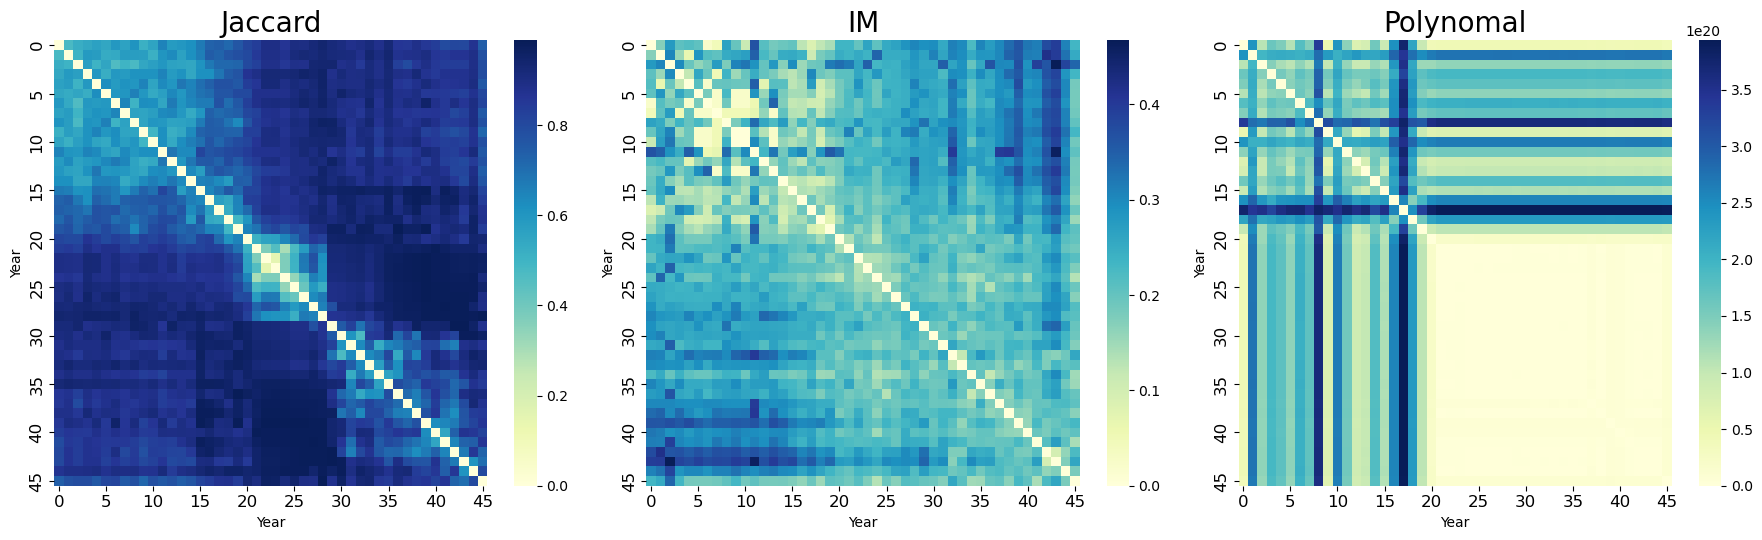

In [ ]:
# Create subplots for each dissimilarity matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

# Plot heatmap for dissimilarity matrix 1
sns.heatmap(dissimilarity_matrix_BIH_jaccard, annot=False, cmap="YlGnBu", xticklabels=5, yticklabels=5, fmt=".2f", ax=axes[0])
axes[0].set_title("Jaccard", fontsize=20)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Year")
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot heatmap for dissimilarity matrix 2
sns.heatmap(dissimilarity_matrix_BIH_IM, annot=False, cmap="YlGnBu", xticklabels=5, yticklabels=5, fmt=".2f", ax=axes[1])
axes[1].set_title("IM", fontsize=20)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Year")
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Plot heatmap for dissimilarity matrix 3
sns.heatmap(dissimilarity_matrix_BIH_poly, annot=False, cmap="YlGnBu", xticklabels=5, yticklabels=5, fmt=".2f", ax=axes[2])
axes[2].set_title("Polynomal", fontsize=20)
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Year")
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

### Syria

In [ ]:
## parameters
orig_filter = "SYR"
max_year = df_subset['year'].max()
min_year = df_subset['year'].min()
years = range (min_year, max_year + 1)

## empty graph storing object
graphs_SYR = []  

## loop to create yearly graphs for RWA
for year in years:
    G = df_to_network_foryear (orig_filter, year, "forced_mig", show_plot = False)
    if G:
        graphs_SYR.append (G)

In [ ]:
## computing dissimilarity matrix
dissimilarity_matrix_SYR_jaccard = create_dissimilarity_matrix (graphs_SYR, weighted_jaccard_distance)
dissimilarity_matrix_SYR_IM = create_dissimilarity_matrix (graphs_SYR, weighted_ipsenMikhailov_distance)
dissimilarity_matrix_SYR_poly = create_dissimilarity_matrix (graphs_SYR, weighted_polynomial_distance)

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1851550651.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight='weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1851550651.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight='weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1751056022.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1751056022.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix

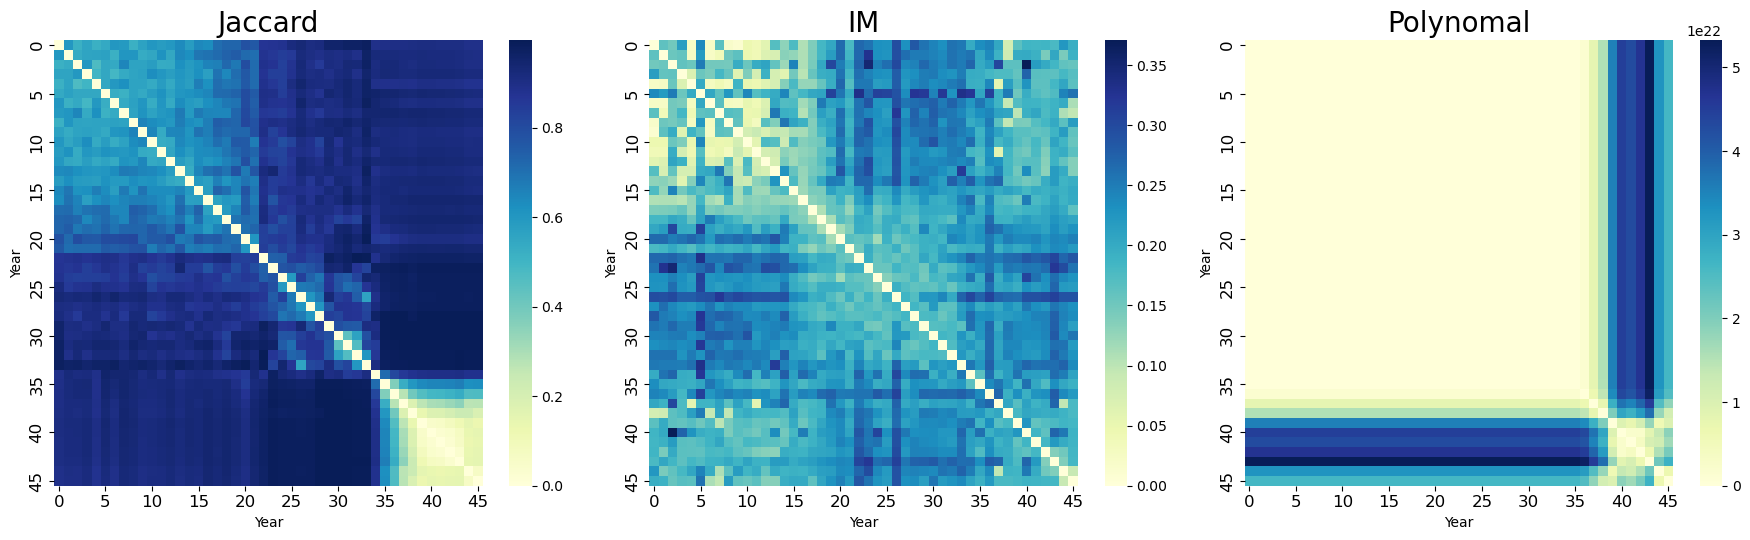

In [ ]:
# Create subplots for each dissimilarity matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

# Plot heatmap for dissimilarity matrix 1
sns.heatmap(dissimilarity_matrix_SYR_jaccard, annot=False, cmap="YlGnBu", xticklabels=5, yticklabels=5, fmt=".2f", ax=axes[0])
axes[0].set_title("Jaccard", fontsize=20)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Year")
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot heatmap for dissimilarity matrix 2
sns.heatmap(dissimilarity_matrix_SYR_IM, annot=False, cmap="YlGnBu", xticklabels=5, yticklabels=5, fmt=".2f", ax=axes[1])
axes[1].set_title("IM", fontsize=20)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Year")
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Plot heatmap for dissimilarity matrix 3
sns.heatmap(dissimilarity_matrix_SYR_poly, annot=False, cmap="YlGnBu", xticklabels=5, yticklabels=5, fmt=".2f", ax=axes[2])
axes[2].set_title("Polynomal", fontsize=20)
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Year")
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

## kNN Metagraphs (Hypothesis 1)

In [ ]:
## adjusting graph conversion function for the metagraph
def df_to_network_foryear2 (orig_filter, year, edge_from, show_plot=True, spring=True):
    
    # Isolating data for the specified year
    dat = df_subset[df_subset['year'] == year]

    # Create a list of all countries
    all_countries = set(dat['orig'].unique()).union(set(dat['dest'].unique()))

    # Create an empty graph with all countries as nodes
    G = nx.Graph()
    G.add_nodes_from(all_countries)

    # Create a sub-dataframe for the specified origin country
    sub_dat = dat[dat['orig'] == orig_filter]

    # Add edges only between the origin country and its connected destinations
    for dest, value in zip(sub_dat['dest'], sub_dat[edge_from]):
        G.add_edge(orig_filter, dest, weight=value)

    # If show_plot=True
    if show_plot:
        # Figure baseline
        plt.figure(figsize=(10, 6))

        # Positioning
        if spring:
            pos = nx.spring_layout(G)  # Positioning nodes using spring layout algorithm
        else:
            pos = nx.random_layout(G)

        # Positioning of labels
        pos_labels = {key: (value[0], value[1] + 0.05) for key, value in pos.items()}  # Label positions

        nx.draw_networkx(G, pos,
                         with_labels=True,
                         node_size=10,
                         node_color='skyblue',
                         font_size=10,
                         font_weight='bold')

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        # Setting title
        if edge_from == "forced_mig":
            plt.title(f'Refugee Flow Network out of {orig_filter} in {year}')
        elif edge_from == "link":
            plt.title(f'Ethno-cultural Linkage Network out of {orig_filter} in {year}')
        else:
            plt.title(f'Network out of {orig_filter} in {year}')

        plt.show()

    # Return network graph object as well
    return G


In [ ]:
## re-doing the masterlist
max_year = df_subset['year'].max()
min_year = df_subset['year'].min()
years = range (min_year, max_year + 1)

## empty graph storing object
graphs_RWA = []
graphs_BIH = []
graphs_SYR = []

## loop to create yearly graphs for RWA
for year in years:
    G = df_to_network_foryear2 ("RWA", year, "forced_mig", show_plot = False)
    if G:
        graphs_RWA.append (G)
        
## loop to create yearly graphs for BIH
for year in years:
    G = df_to_network_foryear2 ("BIH", year, "forced_mig", show_plot = False)
    if G:
        graphs_BIH.append (G)

## loop to create yearly graphs for SYR
for year in years:
    G = df_to_network_foryear2 ("SYR", year, "forced_mig", show_plot = False)
    if G:
        graphs_SYR.append (G)

###  Jaccard kNN metagraph

In [ ]:
## combining lists
graphs_megalist = graphs_RWA + graphs_BIH + graphs_SYR

## dissimilarity matrix for the mega-list
mega_dissimilarity_matrix_jaccard = create_dissimilarity_matrix (graphs_megalist, weighted_jaccard_distance)

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1851550651.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight='weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/1851550651.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight='weight').todense()


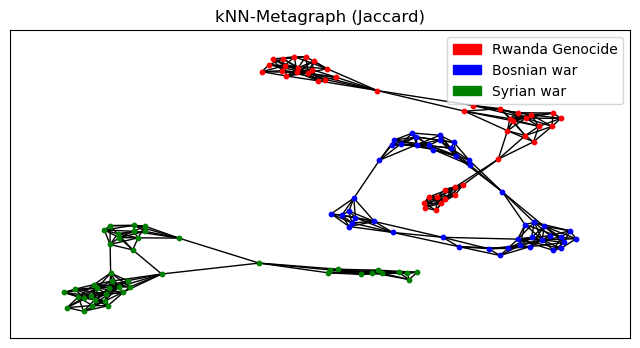

In [ ]:
## create kNN-metagraph
k = 5  # Number of nearest neighbors
edges_j = []

# Find k nearest neighbors for each graph in the mega-list
for i in range(len(graphs_megalist)):
    nearest_neighbors = np.argsort(mega_dissimilarity_matrix_jaccard[i])[:k+1]  # +1 to include itself
    nearest_neighbors = nearest_neighbors[nearest_neighbors != i]  # Exclude itself
    edges_j.extend([(i, nn) for nn in nearest_neighbors])

# Assign colors to nodes based on orig_filter
node_colors_j = []
node_labels_j = []  # List to hold node labels
for i in range(len(graphs_megalist)):
    if i < len(graphs_RWA):
        node_colors_j.append('red')
        node_labels_j.append('Rwanda Genocide')
    elif i < len(graphs_RWA) + len(graphs_BIH):
        node_colors_j.append('blue')
        node_labels_j.append('Bosnian war')
    else:
        node_colors_j.append('green')
        node_labels_j.append('Syrian war')

# Plot the metagraph
plt.figure(figsize=(8, 4))
G_meta_j = nx.Graph()
G_meta_j.add_edges_from(edges_j)

# Assigning node colors and labels
for i, color, label in zip(range(len(graphs_megalist)), node_colors_j, node_labels_j):
    G_meta_j.nodes[i]['color'] = color
    G_meta_j.nodes[i]['label'] = label
    
pos_j = nx.spring_layout(G_meta_j)

# Draw nodes with colors
for color, (node, position) in zip(node_colors_j, pos_j.items()):
    nx.draw_networkx_nodes(G_meta_j, pos_j, [node], node_color=color, node_size=10)

nx.draw_networkx_edges(G_meta_j, pos_j)

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(['red', 'blue', 'green'], ['Rwanda Genocide', 'Bosnian war', 'Syrian war'])]

# Add legend
plt.legend(handles=legend_patches)

plt.title("kNN-Metagraph (Jaccard)")
plt.show()

### IM kNN metagraph

In [ ]:
# new dissimilarity matrix 
mega_dissimilarity_matrix_IM = create_dissimilarity_matrix (graphs_megalist, weighted_ipsenMikhailov_distance)

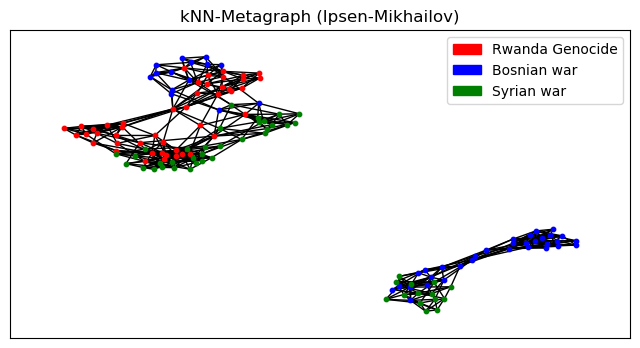

In [ ]:
# Create kNN-metagraph
k = 5  # Number of nearest neighbors
edges_IM = []

# Find k nearest neighbors for each graph in the mega-list
for i in range(len(graphs_megalist)):
    nearest_neighbors = np.argsort(mega_dissimilarity_matrix_IM[i])[:k+1]  # +1 to include itself
    nearest_neighbors = nearest_neighbors[nearest_neighbors != i]  # Exclude itself
    edges_IM.extend([(i, nn) for nn in nearest_neighbors])

# Assign colors to nodes based on orig_filter
node_colors_IM = []
node_labels_IM = []  # List to hold node labels
for i in range(len(graphs_megalist)):
    if i < len(graphs_RWA):
        node_colors_IM.append('red')
        node_labels_IM.append('Rwanda Genocide')
    elif i < len(graphs_RWA) + len(graphs_BIH):
        node_colors_IM.append('blue')
        node_labels_IM.append('Bosnian war')
    else:
        node_colors_IM.append('green')
        node_labels_IM.append('Syrian war')

# Plot the metagraph
plt.figure(figsize=(8, 4))
G_meta_IM = nx.Graph()
G_meta_IM.add_edges_from(edges_IM)

# Assigning node colors and labels
for i, color, label in zip(range(len(graphs_megalist)), node_colors_IM, node_labels_IM):
    G_meta_IM.nodes[i]['color'] = color
    G_meta_IM.nodes[i]['label'] = label

pos_IM = nx.spring_layout(G_meta_IM)

# Draw nodes with colors
for color, (node, position) in zip(node_colors_IM, pos_IM.items()):
    nx.draw_networkx_nodes(G_meta_IM, pos_IM, [node], node_color=color, node_size=10)

nx.draw_networkx_edges(G_meta_IM, pos_IM)

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(['red', 'blue', 'green'], ['Rwanda Genocide', 'Bosnian war', 'Syrian war'])]

# Add legend
plt.legend(handles=legend_patches)

plt.title("kNN-Metagraph (Ipsen-Mikhailov)")
plt.show()

### Polynomial kNN metagraph

In [ ]:
# new dissimilarity matrix 
mega_dissimilarity_matrix_poly = create_dissimilarity_matrix (graphs_megalist, weighted_polynomial_distance)

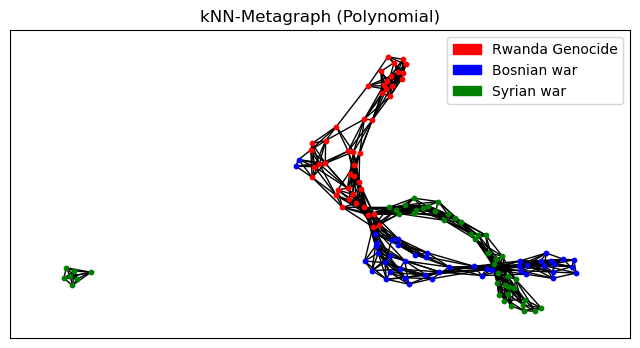

In [ ]:
# Create kNN-metagraph
k = 5  # Number of nearest neighbors
edges_p = []

# Find k nearest neighbors for each graph in the mega-list
for i in range(len(graphs_megalist)):
    nearest_neighbors = np.argsort(mega_dissimilarity_matrix_poly[i])[:k+1]  # +1 to include itself
    nearest_neighbors = nearest_neighbors[nearest_neighbors != i]  # Exclude itself
    edges_p.extend([(i, nn) for nn in nearest_neighbors])

# Assign colors to nodes based on orig_filter
node_colors_p = []
node_labels_p = []  # List to hold node labels
for i in range(len(graphs_megalist)):
    if i < len(graphs_RWA):
        node_colors_p.append('red')
        node_labels_p.append('Rwanda Genocide')
    elif i < len(graphs_RWA) + len(graphs_BIH):
        node_colors_p.append('blue')
        node_labels_p.append('Bosnian war')
    else:
        node_colors_p.append('green')
        node_labels_p.append('Syrian war')

# Plot the metagraph
plt.figure(figsize=(8, 4))
G_meta_p = nx.Graph()
G_meta_p.add_edges_from(edges_p)

# Assigning node colors and labels
for i, color, label in zip(range(len(graphs_megalist)), node_colors_p, node_labels_p):
    G_meta_p.nodes[i]['color'] = color
    G_meta_p.nodes[i]['label'] = label
    
pos_p = nx.spring_layout(G_meta_p)

# Draw nodes with colors
for color, (node, position) in zip(node_colors_p, pos_p.items()):
    nx.draw_networkx_nodes(G_meta_p, pos_p, [node], node_color=color, node_size=10)

nx.draw_networkx_edges(G_meta_p, pos_p)

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(['red', 'blue', 'green'], ['Rwanda Genocide', 'Bosnian war', 'Syrian war'])]

# Add legend
plt.legend(handles=legend_patches)

plt.title("kNN-Metagraph (Polynomial)")
plt.show()

### Friedman-Rafsky Test

In [ ]:
## function for FR test
def fr_test (metagraph, num_permutations = 1000):
    
    # edge count of metagraph
    edge_number = len (metagraph.edges())
    
    # getting original same-label edge count
    original_same_label_edge_count = 0
    for u, v in G.edges():
        if G.nodes[u]['label'] == G.nodes[v]['label']:
            original_same_label_edge_count += 1
    
    # counter function
    def count_same_label_edges(graph):
        same_label_edge_count = 0
        for u, v in graph.edges():
            if graph.nodes[u]['label'] == graph.nodes[v]['label']:
                same_label_edge_count += 1
        return same_label_edge_count
    
    # permutations
    same_label_edge_counts = []
    for _ in range(num_permutations):
        
        # permutation procedure
        permuted_graph = copy.deepcopy(G) # copy original
        permuted_graph.remove_edges_from(list(permuted_graph.edges())) # remove edges
        all_possible_edges = [(u, v) for u in permuted_graph.nodes() for v in permuted_graph.nodes() if u != v]
        random.shuffle(all_possible_edges) # random shuffle
        for edge in all_possible_edges[:edge_number]:
            permuted_graph.add_edge(edge[0], edge[1])
        
        # count same-label edges for this permutation
        same_label_edge_count = count_same_label_edges(permuted_graph)
        same_label_edge_counts.append(same_label_edge_count)
    
    # test (number of permutations where the same-label edge count is greater than or equal to the original count)
    num_permutations_greater = sum(count >= original_same_label_edge_count for count in same_label_edge_counts)
    p_value = num_permutations_greater / num_permutations
    
    # return statement
    return (p_value)

In [ ]:
## applying FR test to jaccard
print (fr_test (G_meta_j, num_permutations = 1000))

0.0


In [ ]:
## applying FR test to polynomial
print (fr_test (G_meta_p, num_permutations = 1000))

0.0


In [ ]:
## applying FR test to IM
print (fr_test (G_meta_IM, num_permutations = 1000))

0.0


## Refugee-Ethnic Kin Convergence Analysis (Hypothesis 2)

In [ ]:
## functions

## function to normalize similarity scores to the range [0, 1]
def normalise (scores):
    min_score = min(scores)
    max_score = max(scores)
    return [(s - min_score) / (max_score - min_score) for s in scores]

## function for first-order Autoregressive Model and time series analysis
def fit_autoregressive_model(similarity_scores):
    model = AutoReg(similarity_scores, lags=1)
    model_fit = model.fit()
    return model_fit

def analyze_time_series(series_list):
    results = []

    for series_name, series_data in series_list:

        # Fit autoregressive model
        model_fit = fit_autoregressive_model(series_data)

        # Extract coefficient and its significance
        coefficient = model_fit.params[1] 
        p_value = model_fit.pvalues[1] 

        results.append((series_name, coefficient, p_value))

    # Create DataFrame
    df = pd.DataFrame(results, columns=['Series Name', 'Coefficient', 'P-value'])
    return df

In [ ]:
## creating unweighted versions of my distance functions

# Jaccard
def unweighted_jaccard_distance(G1, G2):
    
    # getting adjacency matrices of the graphs
    A1 = nx.linalg.graphmatrix.adjacency_matrix (G1).todense()
    A2 = nx.linalg.graphmatrix.adjacency_matrix (G2).todense()

    # computing numerator and denominator of the weighted Jaccard distance formula
    numerator = np.sum (np.abs (A1 - A2))
    denominator = np.sum (np.maximum (A1, A2))

    # computing the weighted Jaccard distance
    jaccard_distance = numerator / denominator
    return jaccard_distance

# IM
def unweighted_ipsenMikhailov_distance (G1, G2, hwhm = 0.08): 
    
    # adjacency matrices
    A1 = nx.linalg.graphmatrix.adjacency_matrix (G1).todense()
    A2 = nx.linalg.graphmatrix.adjacency_matrix (G2).todense()
    
    # baseline function for IM distances
    def IMdistance (A1, A2, gamma): 

        # number of nodes 
        n = len(A1)

        # spectral density of A1 
        L1 = laplacian (A1, normed = False) # Laplacian matrix
        w1 = np.sqrt (np.abs (eigh (L1)[0][1:])) # vibrational frequency
        norm1 = (n - 1) * np.pi / 2 - np.sum (np.arctan (-w1 / gamma)) # normalisation constant (l2 norm)
        density1 = lambda w: np.sum (gamma / ((w - w1) ** 2 + gamma**2)) / norm1 # spectral density (equation 5 in paper)

        # spectral density of A2
        L2 = laplacian (A2, normed = False) # Laplacian matrix
        w2 = np.sqrt (np.abs (eigh (L2)[0][1:])) # vibrational frequency
        norm2 = (n - 1) * np.pi / 2 - np.sum (np.arctan (-w2 / gamma)) # normalisation constant (l2 norm)
        density2 = lambda w: np.sum (gamma / ((w - w2) ** 2 + gamma**2)) / norm2 # spectral density (equation 5 in paper)

        # getting the IM distance using the two spectral densities (equation 6 in paper)
        return np.sqrt (quad (lambda w: (density1(w) - density2(w)) ** 2, 
                              0, 
                              np.inf, 
                              limit = limit)[0])
    
    # computing distance
    distance = IMdistance (A1, A2, gamma)
    return distance

# poly 
def unweighted_polynomial_distance (G1, G2, k = 3, alpha = 1): 

    # getting adjacency matrices of the graphs
    A1 = nx.linalg.graphmatrix.adjacency_matrix (G1).todense()
    A2 = nx.linalg.graphmatrix.adjacency_matrix (G2).todense()
    
    # P(A) (i.e. equation 8 in my paper) 
    def p_A (A, k, alpha): 
        
        # eigen-decomposition
        eigVals, eigVec = np.linalg.eig(A)
        
        # defining polynomial p(x) 
        def p_x(degree):

            # equation 7 in my paper
            return eigVals ** degree / (np.shape(A)[0] - 1) ** (alpha * (degree - 1))
        
        # diagonal matrix constructed from the sum of the polynomial transformations
        W = np.diag (sum([p_x(k) for k in range (1, k + 1)]))
        
        # polynomial transformation of the adjacency matrix 
        pA = np.dot (np.dot (eigVec, W), eigVec.T)
        return pA
    
    # applying polynomial to each adjacency matrix
    p_A1 = p_A (A1, k, alpha)
    p_A2 = p_A (A2, k, alpha)

    # getting N
    N = A1.shape[0]
    
    # polynomial distance
    polyDist = np.linalg.norm (p_A1 - p_A2) / N ** 2 # uses 2-norm by default
    return polyDist

In [ ]:
## creating ethno-cultural similarity network
G_eth_RWA = df_to_network_foryear2 ("RWA", year, "link", show_plot = False)
G_eth_BIH = df_to_network_foryear2 ("BIH", year, "link", show_plot = False)
G_eth_SYR = df_to_network_foryear2 ("SYR", year, "link", show_plot = False)

### Rwanda

In [ ]:
## creating years object
years = range (len (graphs_RWA))

## lists to store metrics
jaccard_scores_RWA = []
ipsen_scores_RWA = []
poly_scores_RWA = []

## getting scores for each graph
for graph in graphs_RWA:
    jaccard_scores_RWA.append (unweighted_jaccard_distance (G_eth_RWA, graph))
    ipsen_scores_RWA.append (unweighted_ipsenMikhailov_distance (G_eth_RWA, graph))
    poly_scores_RWA.append (unweighted_polynomial_distance (G_eth_RWA, graph))

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1).todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2).todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:41: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1).todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:42: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2).todense()
/var/folders/z6/nyjj

In [ ]:
## normalising
jaccard_scores_RWA_norm = normalise (jaccard_scores_RWA)
ipsen_scores_RWA_norm = normalise (ipsen_scores_RWA)
poly_scores_RWA_norm = normalise (poly_scores_RWA)

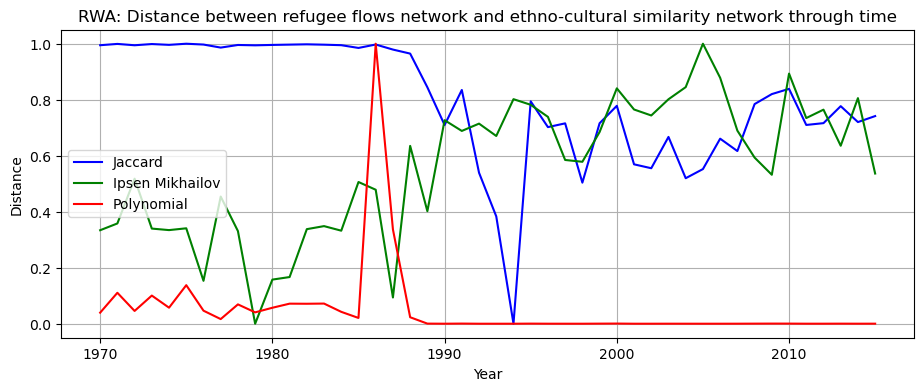

In [ ]:
# plotting for Rwands
plt.figure(figsize = (11, 4))

plt.plot (years, jaccard_scores_RWA_norm, label = 'Jaccard', color='blue')
plt.plot (years, ipsen_scores_RWA_norm, label = 'Ipsen Mikhailov', color='green')
plt.plot (years, poly_scores_RWA_norm, label = 'Polynomial', color='red')

plt.xlabel ('Year')
plt.ylabel ('Distance')
plt.title ('RWA: Distance between refugee flows network and ethno-cultural similarity network through time')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Analyze time series
series_list = [("Jaccard (RWA)", jaccard_scores_RWA_norm),
               ("IM (RWA)", ipsen_scores_RWA_norm),
               ("Polynomial (RWA)", poly_scores_RWA_norm)]

results_df = analyze_time_series (series_list)
display (results_df)

,Series Name,Coefficient,P-value
0,Jaccard (RWA),0.703124,1.431947e-11
1,IM (RWA),0.710986,4.505449e-12
2,Polynomial (RWA),0.283272,4.783256e-02


### Bosnia-Herzegovina

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1).todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2).todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:41: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1).todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:42: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2).todense()
/var/folders/z6/nyjj

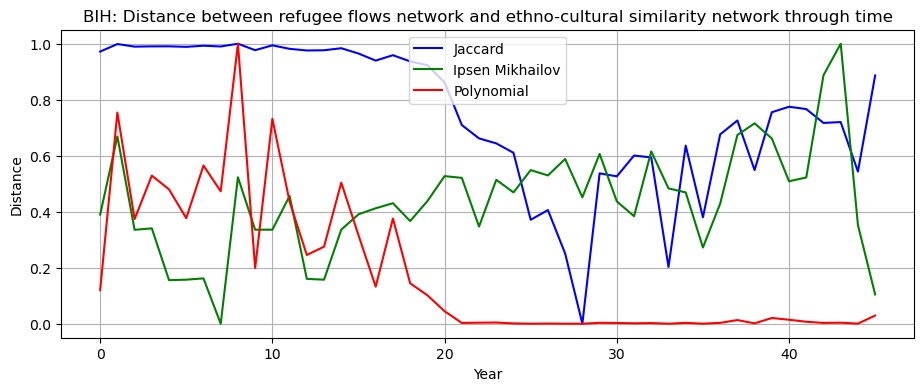

In [ ]:
years = range (len (graphs_BIH))
jaccard_scores_BIH = []
ipsen_scores_BIH = []
poly_scores_BIH = []

for graph in graphs_BIH:
    jaccard_scores_BIH.append (unweighted_jaccard_distance (G_eth_BIH, graph))
    ipsen_scores_BIH.append (unweighted_ipsenMikhailov_distance (G_eth_BIH, graph))
    poly_scores_BIH.append (unweighted_polynomial_distance (G_eth_BIH, graph))
    
jaccard_scores_BIH_norm = normalise (jaccard_scores_BIH)
ipsen_scores_BIH_norm = normalise (ipsen_scores_BIH)
poly_scores_BIH_norm = normalise (poly_scores_BIH)

# Plotting
plt.figure(figsize = (11, 4))

plt.plot (years, jaccard_scores_BIH_norm, label = 'Jaccard', color='blue')
plt.plot (years, ipsen_scores_BIH_norm, label = 'Ipsen Mikhailov', color='green')
plt.plot (years, poly_scores_BIH_norm, label = 'Polynomial', color='red')

plt.xlabel ('Year')
plt.ylabel ('Distance')
plt.title ('BIH: Distance between refugee flows network and ethno-cultural similarity network through time')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Analyze time series
series_list = [("Jaccard (BIH)", jaccard_scores_BIH_norm),
               ("IM (BIH)", ipsen_scores_BIH_norm),
               ("Polynomial (BIH)", poly_scores_BIH_norm)]

results_df = analyze_time_series (series_list)
display (results_df)

,Series Name,Coefficient,P-value
0,Jaccard (BIH),0.784198,8.000389e-18
1,IM (BIH),0.498371,2.262469e-04
2,Polynomial (BIH),0.617334,1.651273e-07


### Syria

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1).todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2).todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:41: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1).todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_2792/3806667317.py:42: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2).todense()
/var/folders/z6/nyjj

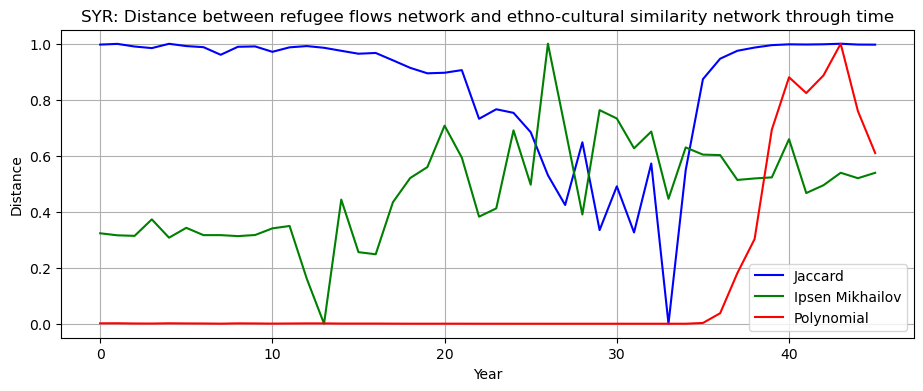

In [ ]:
years = range (len (graphs_SYR))
jaccard_scores_SYR = []
ipsen_scores_SYR = []
poly_scores_SYR = []

for graph in graphs_SYR:
    jaccard_scores_SYR.append (unweighted_jaccard_distance (G_eth_SYR, graph))
    ipsen_scores_SYR.append (unweighted_ipsenMikhailov_distance (G_eth_SYR, graph))
    poly_scores_SYR.append (unweighted_polynomial_distance (G_eth_SYR, graph))
    
jaccard_scores_SYR_norm = normalise (jaccard_scores_SYR)
ipsen_scores_SYR_norm = normalise (ipsen_scores_SYR)
poly_scores_SYR_norm = normalise (poly_scores_SYR)

# Plotting
plt.figure(figsize = (11, 4))

plt.plot (years, jaccard_scores_SYR_norm, label = 'Jaccard', color='blue')
plt.plot (years, ipsen_scores_SYR_norm, label = 'Ipsen Mikhailov', color='green')
plt.plot (years, poly_scores_SYR_norm, label = 'Polynomial', color='red')

plt.xlabel ('Year')
plt.ylabel ('Distance')
plt.title ('SYR: Distance between refugee flows network and ethno-cultural similarity network through time')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Analyze time series
series_list = [("Jaccard (SYR)", jaccard_scores_SYR_norm),
               ("IM (SYR)", ipsen_scores_SYR_norm),
               ("Polynomial (SYR)", poly_scores_SYR_norm)]

results_df = analyze_time_series (series_list)
display (results_df)

,Series Name,Coefficient,P-value
0,Jaccard (SYR),0.779380,7.133466e-17
1,IM (SYR),0.556866,5.644670e-06
2,Polynomial (SYR),0.986095,1.822038e-114
